# Classifier based on beta-band

## Looking at TFR

In [16]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import mne

data_dir = "/Users/martin.iniguez/Desktop/master-thesis/opm-thesis/data/digits_epochs/"
file = data_dir + "freq_bands/all_data_all_epochs.pkl"
all_epochs = pickle.load(open(file, "rb")).pick(picks="meg", exclude="bads")
all_epochs = all_epochs.decimate(2)

In [2]:
labels = np.unique(all_epochs.events[:, -1])
fmin = 21
fmax = 30
freqs = np.arange(fmin, fmax + 1, 2)
n_cycles = freqs / 2  # different number of cycle per frequency

if os.path.exists(data_dir + "all_epochs_tfr_beta.pkl"):
    with open(data_dir + "all_epochs_tfr_beta.pkl", "rb") as f:
        power = pickle.load(f)
else:
    power = {}
    for idx, label in enumerate(labels):
        valid_epochs_mask = np.isin(all_epochs.events[:, -1], label)
        label_epochs = all_epochs[valid_epochs_mask]

        power[idx + 1] = mne.time_frequency.tfr_morlet(
            label_epochs,
            freqs=freqs,
            n_cycles=n_cycles,
            n_jobs=1,
            return_itc=False,
            decim=3,
        )
    with open(data_dir + "all_epochs_tfr_beta.pkl", "wb") as f:
        pickle.dump(power, f)

if os.path.exists(data_dir + "individual_epoch_tfr_beta.pkl"):
    with open(data_dir + "individual_epoch_tfr_beta.pkl", "rb") as f:
        power_per_epoch = pickle.load(f)

else:
    power_per_epoch = mne.time_frequency.tfr_morlet(
        all_epochs,
        freqs=freqs,
        n_cycles=n_cycles,
        n_jobs=5,
        return_itc=False,
        decim=3,
        average=False,
    )
    with open(data_dir + "individual_epoch_tfr_beta.pkl", "wb") as f:
        pickle.dump(power_per_epoch, f)

## Plotting TFR


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: logratio)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: logratio)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: logratio)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: logratio)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: logratio)


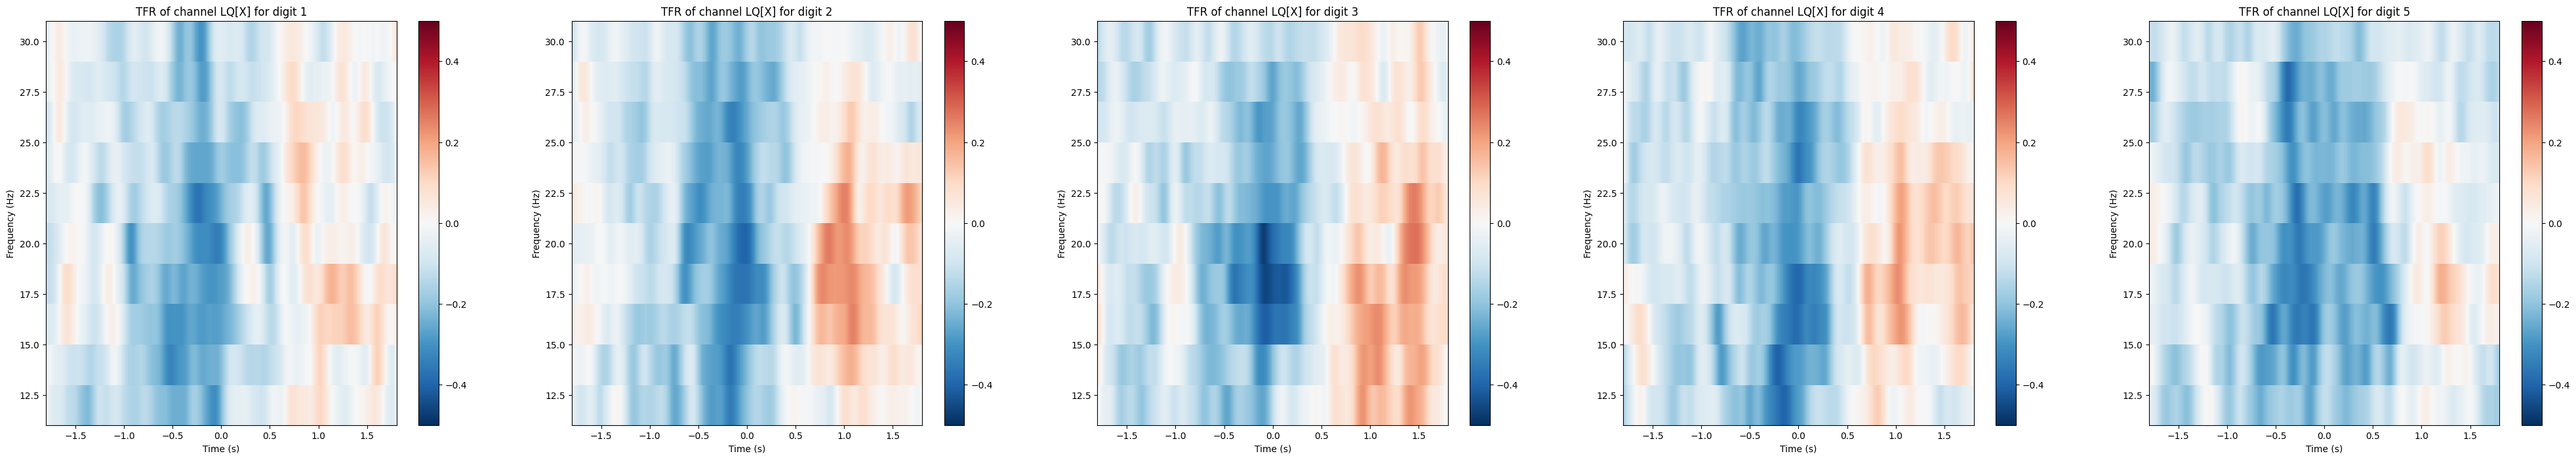

In [3]:
center_channel = "LQ[X]"
idx_channel = all_epochs.ch_names.index(center_channel)

conditions = [1, 2, 3, 4, 5]
# Create a figure with subplots
fig, axes = plt.subplots(
    1, len(conditions), figsize=(50, 8)
)  # Adjust figsize as needed

for i, condition in enumerate(conditions):
    # Select the subplot
    ax = axes[i]

    # Plot the 5 different digits in a subplot horziontally
    power[condition].plot(
        [idx_channel],
        baseline=(-2, -0.57),
        mode="logratio",
        tmin=-1.8,
        tmax=1.8,
        axes=ax,
        show=False,
        vmin=-0.5,
        vmax=0.5,
    )
    ax.set_title("TFR of channel " + center_channel + " for digit " + str(i + 1))

In [4]:
# Function that takes a array and givees the indices where the absolute value is lower than 1.8
def find_indices(array, threshold=1.8):
    indices = []
    for idx, value in enumerate(array):
        if np.abs(value) < threshold:
            indices.append(idx)
    return indices

In [5]:
from mne.baseline import rescale

power_scaled = []

for i in range(5):
    data = power[i + 1].data
    times = power[i + 1].times
    baseline = (-2, -0.57)
    data = rescale(data, times, baseline, mode="logratio")
    if np.iscomplexobj(data):
        data = (data * data.conj()).real
    time_indices = find_indices(times, threshold=1.75)
    times = times[time_indices]
    data = data.mean(axis=1)
    power_scaled.append(data[:, time_indices])

power_scaled = np.array(power_scaled)
variance = np.var(power_scaled[:], axis=2)
mean = np.mean(power_scaled[:], axis=2)
highest_variance = np.argmax(variance, axis=0) + 1

Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


Highest variance in condition: 3


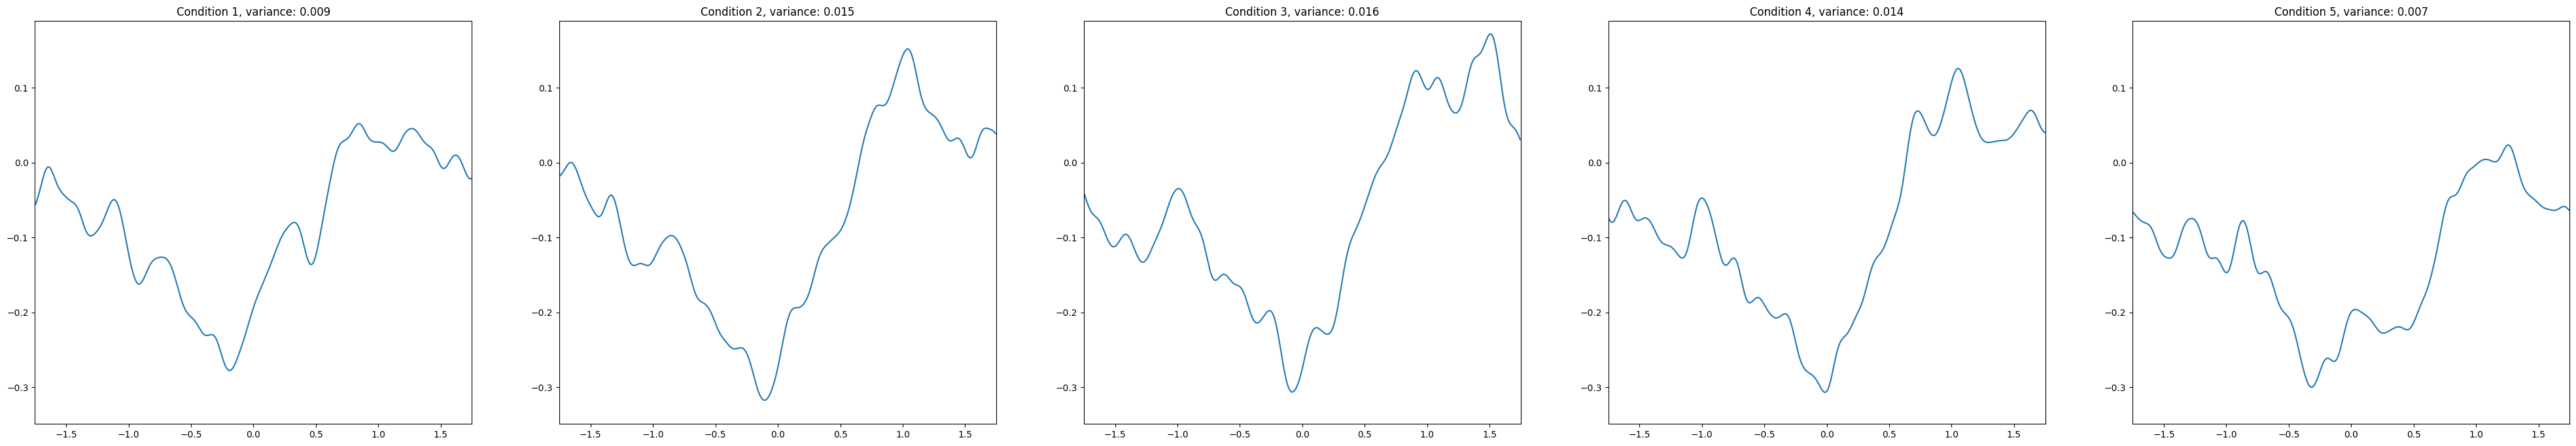

In [14]:
center_channel = "LQ[X]"
idx_channel = all_epochs.ch_names.index(center_channel)

fig, axes = plt.subplots(1, 5, figsize=(50, 8))  # Adjust figsize as needed

for i, condition in enumerate(conditions):
    # Select the subplot
    ax = axes[i]

    power_beta = power_scaled[i][idx_channel]
    ax.plot(times, power_beta, label="Beta band")
    ax.set_title(f"Condition {condition}, variance: {np.var(power_beta):.3f}")
    lim_y_up = np.max(power_scaled[:, idx_channel])
    if lim_y_up > 0:
        lim_y_up = lim_y_up * 1.1
    else:
        lim_y_up = lim_y_up * 0.9
    lim_y_down = np.min(power_scaled[:, idx_channel])

    if lim_y_down > 0:
        lim_y_down = lim_y_down * 0.9
    else:
        lim_y_down = lim_y_down * 1.1
    ax.set_ylim(lim_y_down, lim_y_up)
    ax.set_xlim(-1.75, 1.75)

print("Highest variance in condition:", highest_variance[idx_channel])

In [15]:
power_per_epoch_scaled = []

for i in range(len(power_per_epoch)):
    data = power_per_epoch[i].data[0]
    times = power_per_epoch[i].times
    baseline = (-2, -0.57)
    data = rescale(data, times, baseline, mode="logratio")
    if np.iscomplexobj(data):
        data = (data * data.conj()).real
    time_indices = find_indices(times, threshold=1.75)
    times = times[time_indices]

    data = data.mean(axis=1)
    power_per_epoch_scaled.append(data[:, time_indices])

power_per_epoch_scaled = np.array(power_per_epoch_scaled)
variance_per_epoch_scaled = np.var(power_per_epoch_scaled, axis=2)
mean_per_epoch_scaled = np.mean(power_per_epoch_scaled, axis=2)

Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode

In [16]:
from opm_thesis.preprocessing.utils import get_closest_sensors

closest_sensors = get_closest_sensors(all_epochs.info, center_channel, num_channels=30)
idx_closest_sensors = [all_epochs.ch_names.index(sensor) for sensor in closest_sensors]

closest_sensors_x = [
    all_epochs.ch_names.index(sensor) for sensor in closest_sensors if "X" in sensor[-2]
]
closest_sensors_y = [
    all_epochs.ch_names.index(sensor) for sensor in closest_sensors if "Y" in sensor[-2]
]
closest_sensors_z = [
    all_epochs.ch_names.index(sensor) for sensor in closest_sensors if "Z" in sensor[-2]
]

In [17]:
print(highest_variance[closest_sensors_x])

# Select which sensors have highest difference of variance between maximum and minimum condition
threshold = 1.5
idx_sensors = []
for idx_sensor in idx_closest_sensors:
    if (
        np.max(variance[:, idx_sensor]) / np.min(variance[:, idx_sensor]) > threshold
        and np.max(variance[:, idx_sensor]) > 0.01
    ):
        idx_sensors.append(idx_sensor)

idx_sensors = np.array(idx_sensors)
print(highest_variance[idx_sensors], idx_sensors)

[3 3 3 3 4 3 4 4 3 1 4 3 3 3 5 3 3 5 2 4 3 3 5 3 1 3 5 2 5 2]
[3 3 3 3 3 2 3 2 3 3 3 3 2 3 2 2 3 2 3 2 3] [154  45  17  14 136  30 152 153  43  15 137  12  13  96  97  37  38 134
  64  65 128]


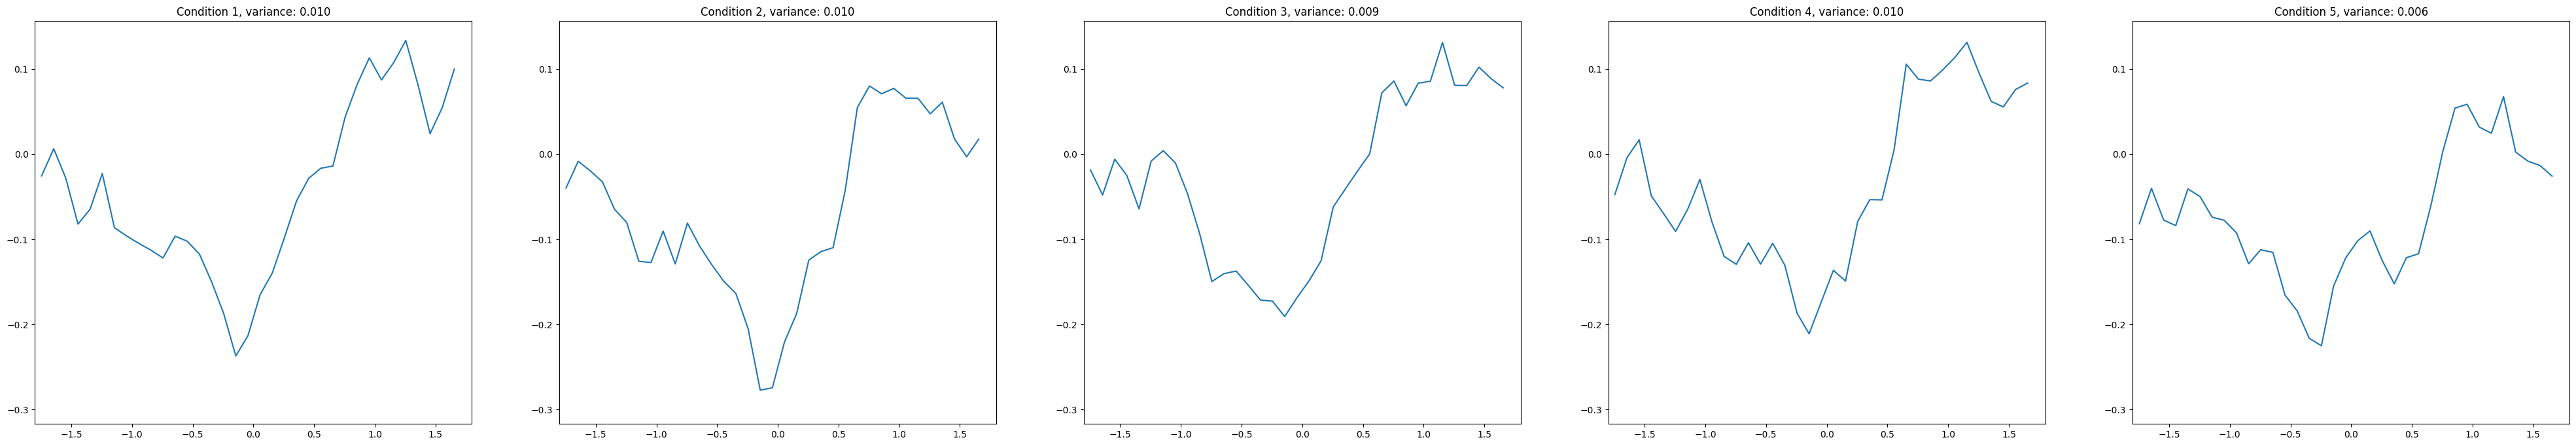

In [18]:
fig, axes = plt.subplots(1, 5, figsize=(50, 8))  # Adjust figsize as needed

for i, condition in enumerate(conditions):
    # Select the subplot
    ax = axes[i]
    channel = 30

    power_beta = power_scaled[i][channel][0:-1:20]
    ax.plot(times[0:-1:20], power_beta, label="Beta band")
    ax.set_title(f"Condition {condition}, variance: {np.var(power_beta):.3f}")

    lim_y_up = np.max(power_scaled[:, channel])
    if lim_y_up > 0:
        lim_y_up = lim_y_up * 1.1
    else:
        lim_y_up = lim_y_up * 0.9
    lim_y_down = np.min(power_scaled[:, channel])

    if lim_y_down > 0:
        lim_y_down = lim_y_down * 0.9
    else:
        lim_y_down = lim_y_down * 1.1
    ax.set_ylim(lim_y_down, lim_y_up)
    ax.set_xlim(-1.8, 1.8)

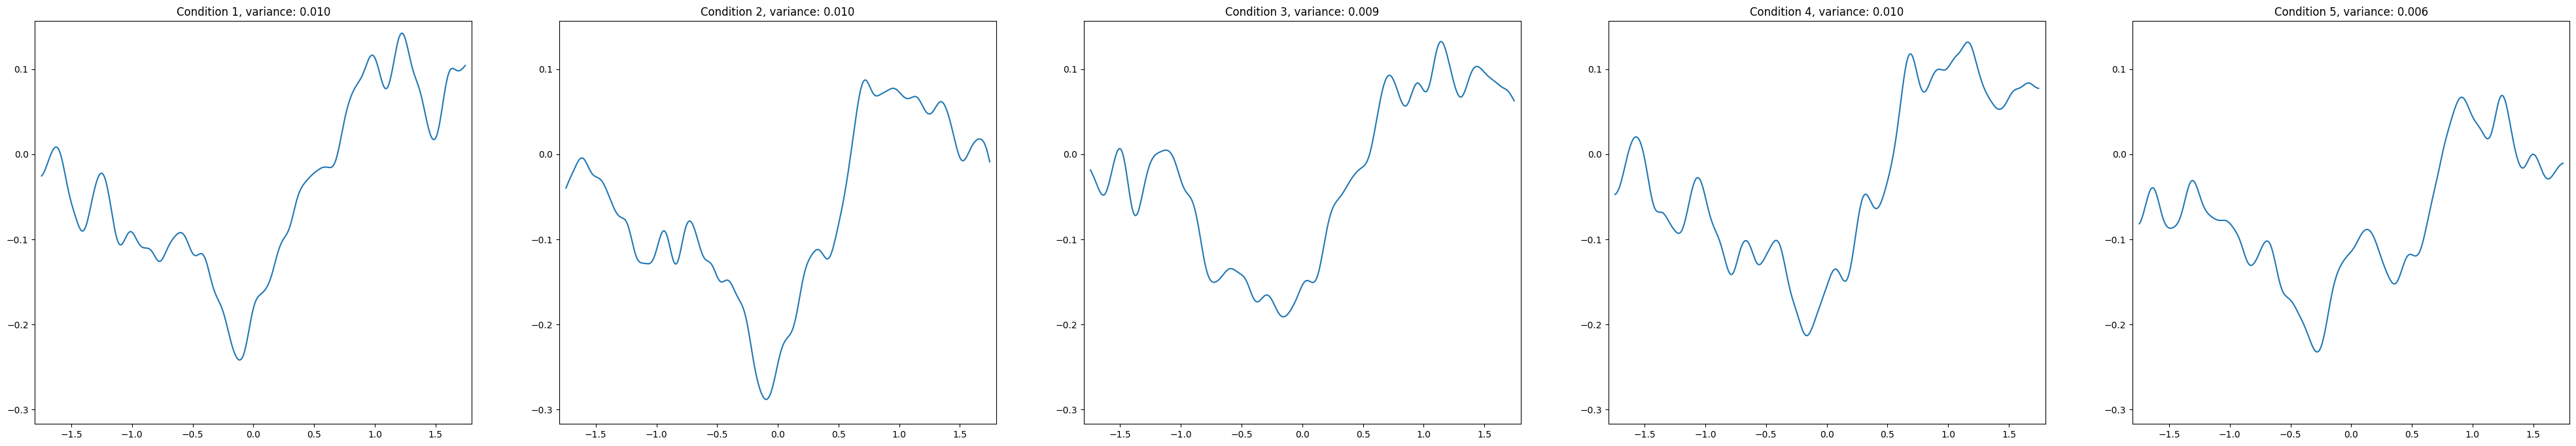

In [19]:
fig, axes = plt.subplots(1, 5, figsize=(50, 8))  # Adjust figsize as needed

for i, condition in enumerate(conditions):
    # Select the subplot
    ax = axes[i]
    channel = 30

    power_beta = power_scaled[i][channel]
    ax.plot(times, power_beta, label="Beta band")
    ax.set_title(f"Condition {condition}, variance: {np.var(power_beta):.3f}")

    lim_y_up = np.max(power_scaled[:, channel])
    if lim_y_up > 0:
        lim_y_up = lim_y_up * 1.1
    else:
        lim_y_up = lim_y_up * 0.9
    lim_y_down = np.min(power_scaled[:, channel])

    if lim_y_down > 0:
        lim_y_down = lim_y_down * 0.9
    else:
        lim_y_down = lim_y_down * 1.1
    ax.set_ylim(lim_y_down, lim_y_up)
    ax.set_xlim(-1.8, 1.8)

## Create a LDA classifier


In [20]:
# Create a LDA classifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score

clf = LDA()
x_data = np.concatenate(
    [
        variance_per_epoch_scaled[:, idx_sensors],
        mean_per_epoch_scaled[:, idx_sensors],
    ],
    axis=1,
)

scores = cross_val_score(
    clf,
    x_data,
    all_epochs.events[:, -1],
    cv=5,
)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Checking for events that are equal to the value 32 or 128

id_pairs = [[2**i, 2**j] for i in range(3, 8) for j in range(i + 1, 8)]

for id_pair in id_pairs:
    indices_to_use = np.where(np.isin(all_epochs.events[:, -1], id_pair))[0]
    some_variances = variance_per_epoch_scaled[indices_to_use]
    some_means = mean_per_epoch_scaled[indices_to_use]
    x_data = np.concatenate(
        [some_variances[:, idx_sensors], some_means[:, idx_sensors]], axis=1
    )
    labels = all_epochs.events[indices_to_use, -1]

    clf = LDA()
    scores = cross_val_score(clf, x_data, labels, cv=5)

    # print accuracy for id_pair
    print(
        f"Accuracy for {id_pair}: {scores.mean()*100:.2f} (+/- {scores.std() * 2*100:.2f})"
    )

Accuracy: 0.21 (+/- 0.08)
Accuracy for [8, 16]: 48.69 (+/- 15.60)
Accuracy for [8, 32]: 54.84 (+/- 7.07)
Accuracy for [8, 64]: 46.47 (+/- 10.59)
Accuracy for [8, 128]: 46.79 (+/- 8.66)
Accuracy for [16, 32]: 55.53 (+/- 18.12)
Accuracy for [16, 64]: 45.81 (+/- 16.52)
Accuracy for [16, 128]: 56.47 (+/- 19.12)
Accuracy for [32, 64]: 41.63 (+/- 8.31)
Accuracy for [32, 128]: 58.06 (+/- 9.12)
Accuracy for [64, 128]: 47.18 (+/- 22.23)


## Create a CNN classifier

In [21]:
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from opm_thesis.classifiers.classifier import VAR_CNN, MyDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

accuracy = []
id_pairs = [[2**i, 2**j] for i in range(3, 8) for j in range(i + 1, 8)]

for id_pair in id_pairs:
    labels = all_epochs.events[:, -1]

    valid_epochs_mask = np.isin(labels, id_pair)
    data = power_per_epoch_scaled[valid_epochs_mask]
    labels = labels[valid_epochs_mask]

    label_mapping = {label: idx for idx, label in enumerate(id_pair)}
    # Map the labels to 0 and 1
    final_targets = np.array(
        [label_mapping[label] for label in labels if label in label_mapping]
    )

    # Split the data into training and testing sets
    train_data, test_data, train_labels, test_labels = train_test_split(
        data, final_targets, test_size=0.2, random_state=42
    )

    # Create PyTorch datasets and loaders
    train_dataset = MyDataset(train_data, train_labels)
    test_dataset = MyDataset(test_data, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Train the classifier and evaluate it
    classifier = VAR_CNN(data.shape[1], data.shape[2], len(id_pair), device, 32, 15)
    classifier.train_model(train_loader, test_loader, num_epochs=50, learning_rate=1e-3)
    accuracy.append(classifier.evaluate(test_loader) * 100)

for idx, id_pair in enumerate(id_pairs):
    print(f"Accuracy for {id_pair}: {accuracy[idx]:.2f}")

KeyboardInterrupt: 

In [ ]:
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from opm_thesis.classifiers.classifier import VAR_CNN, MyDataset

# Versus the others

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

accuracy = []
conditions = [8, 16, 32, 64, 128]

for id in conditions:
    labels = all_epochs.events[:, -1]

    # valid_epochs_mask = np.isin(labels, id_pair)
    data = power_per_epoch_scaled
    labels = labels

    label_mapping = {label: (0 if label != id else 1) for label in conditions}

    # Map the labels to 0 and 1
    final_targets = np.array(
        [label_mapping[label] for label in labels if label in label_mapping]
    )

    # Split the data into training and testing sets
    train_data, test_data, train_labels, test_labels = train_test_split(
        data, final_targets, test_size=0.2, random_state=42, stratify=final_targets
    )

    # Find the number of instances for the minority class in the training set
    min_class_len = min(sum(train_labels == 0), sum(train_labels == 1))

    # Get the indices of each class
    idx_class_0 = np.where(train_labels == 0)[0]
    idx_class_1 = np.where(train_labels == 1)[0]

    # Randomly select 'min_class_len' instances from each class
    np.random.seed(42)
    idx_class_0_downsampled = np.random.choice(idx_class_0, size=min_class_len, replace=False)
    idx_class_1_downsampled = np.random.choice(idx_class_1, size=min_class_len, replace=False)

    # Concatenate the downsampled indices and then get the corresponding data and labels
    train_idx_downsampled = np.concatenate((idx_class_0_downsampled, idx_class_1_downsampled))
    train_data_balanced = train_data[train_idx_downsampled]
    train_labels_balanced = train_labels[train_idx_downsampled]

    # Create PyTorch datasets and loaders
    train_dataset = MyDataset(train_data_balanced, train_labels_balanced)
    test_dataset = MyDataset(test_data, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Train the classifier and evaluate it
    classifier = VAR_CNN(data.shape[1], data.shape[2], len(id_pair), device, 32, 17)
    classifier.train_model(train_loader, test_loader, num_epochs=100, learning_rate=1e-3)
    accuracy.append(classifier.evaluate(test_loader) * 100)

for idx, condition in enumerate(conditions):
    print(f"Accuracy for {condition}: {accuracy[idx]:.2f}")

Epoch [100/100], Test Accuracy: 47.44
Epoch [100/100], Test Accuracy: 37.18
Epoch [100/100], Test Accuracy: 57.69
Epoch [100/100], Test Accuracy: 57.69
Epoch [100/100], Test Accuracy: 62.82
Accuracy for 8: 47.44
Accuracy for 16: 37.18
Accuracy for 32: 57.69
Accuracy for 64: 57.69
Accuracy for 128: 62.82


In [ ]:
# Trying on DeepConvNet
from opm_thesis.classifiers.classifier import DeepConvNet
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from opm_thesis.classifiers.classifier import VAR_CNN, MyDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

accuracy = []
id_pairs = [[2**i, 2**j] for i in range(3, 8) for j in range(i + 1, 8)]

for id_pair in id_pairs:
    labels = all_epochs.events[:, -1]

    valid_epochs_mask = np.isin(labels, id_pair)
    data = power_per_epoch_scaled[valid_epochs_mask]
    labels = labels[valid_epochs_mask]

    label_mapping = {label: idx for idx, label in enumerate(id_pair)}
    # Map the labels to 0 and 1
    final_targets = np.array(
        [label_mapping[label] for label in labels if label in label_mapping]
    )

    # Split the data into training and testing sets
    train_data, test_data, train_labels, test_labels = train_test_split(
        data, final_targets, test_size=0.2, random_state=42
    )

    # Create PyTorch datasets and loaders
    train_dataset = MyDataset(train_data, train_labels)
    test_dataset = MyDataset(test_data, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Train the classifier and evaluate it
    classifier = DeepConvNet(
        data.shape[1],
        data.shape[2],
        len(id_pair),
        device,
    )
    classifier.train_model(train_loader, test_loader, num_epochs=20, learning_rate=1e-3)
    accuracy.append(classifier.evaluate(test_loader) * 100)

for idx, id_pair in enumerate(id_pairs):
    print(f"Accuracy for {id_pair}: {accuracy[idx]:.2f}")

Epoch [1/20], Loss: 0.7516
Epoch [2/20], Loss: 0.7035
Epoch [3/20], Loss: 0.7547
Epoch [4/20], Loss: 0.7196
Epoch [5/20], Loss: 0.6762
Epoch [6/20], Loss: 0.6766
Epoch [7/20], Loss: 0.6773
Epoch [8/20], Loss: 0.7126
Epoch [9/20], Loss: 0.6750
Epoch [10/20], Loss: 0.6779
Epoch [10/20], Test Accuracy: 61.29
Epoch [11/20], Loss: 0.6426
Epoch [12/20], Loss: 0.6590
Epoch [13/20], Loss: 0.6428
Epoch [14/20], Loss: 0.6734
Epoch [15/20], Loss: 0.6453
Epoch [16/20], Loss: 0.6290
Epoch [17/20], Loss: 0.5574
Epoch [18/20], Loss: 0.5178
Epoch [19/20], Loss: 0.5602
Epoch [20/20], Loss: 0.5053
Epoch [20/20], Test Accuracy: 41.94
Epoch [1/20], Loss: 0.8084
Epoch [2/20], Loss: 0.7222
Epoch [3/20], Loss: 0.6499
Epoch [4/20], Loss: 0.7042
Epoch [5/20], Loss: 0.6876
Epoch [6/20], Loss: 0.7118
Epoch [7/20], Loss: 0.7609
Epoch [8/20], Loss: 0.7157
Epoch [9/20], Loss: 0.6777
Epoch [10/20], Loss: 0.6418
Epoch [10/20], Test Accuracy: 45.16
Epoch [11/20], Loss: 0.6516
Epoch [12/20], Loss: 0.6954
Epoch [13/20],

In [ ]:
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from opm_thesis.classifiers.classifier import VAR_CNN, MyDataset

# Versus the others

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

accuracy = []
conditions = [8, 16, 32, 64, 128]

for id in conditions:
    labels = all_epochs.events[:, -1]

    # valid_epochs_mask = np.isin(labels, id_pair)
    data = power_per_epoch_scaled
    labels = labels

    label_mapping = {label: (0 if label != id else 1) for label in conditions}

    # Map the labels to 0 and 1
    final_targets = np.array(
        [label_mapping[label] for label in labels if label in label_mapping]
    )

    # Split the data into training and testing sets
    train_data, test_data, train_labels, test_labels = train_test_split(
        data, final_targets, test_size=0.2, random_state=42, stratify=final_targets
    )

    # Find the number of instances for the minority class in the training set
    min_class_len = min(sum(train_labels == 0), sum(train_labels == 1))

    # Get the indices of each class
    idx_class_0 = np.where(train_labels == 0)[0]
    idx_class_1 = np.where(train_labels == 1)[0]

    # Randomly select 'min_class_len' instances from each class
    np.random.seed(42)
    idx_class_0_downsampled = np.random.choice(
        idx_class_0, size=min_class_len, replace=False
    )
    idx_class_1_downsampled = np.random.choice(
        idx_class_1, size=min_class_len, replace=False
    )

    # Concatenate the downsampled indices and then get the corresponding data and labels
    train_idx_downsampled = np.concatenate(
        (idx_class_0_downsampled, idx_class_1_downsampled)
    )
    train_data_balanced = train_data[train_idx_downsampled]
    train_labels_balanced = train_labels[train_idx_downsampled]

    # Create PyTorch datasets and loaders
    train_dataset = MyDataset(train_data_balanced, train_labels_balanced)
    test_dataset = MyDataset(test_data, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Train the classifier and evaluate it
    classifier = DeepConvNet(
        data.shape[1],
        data.shape[2],
        len(id_pair),
        device,
    )
    classifier.train_model(
        train_loader, test_loader, num_epochs=100, learning_rate=1e-3
    )
    accuracy.append(classifier.evaluate(test_loader) * 100)

for idx, condition in enumerate(conditions):
    print(f"Accuracy for {condition}: {accuracy[idx]:.2f}")

Epoch [1/100], Loss: 0.7061
Epoch [2/100], Loss: 0.7488
Epoch [3/100], Loss: 0.7530
Epoch [4/100], Loss: 0.6833
Epoch [5/100], Loss: 0.7226
Epoch [6/100], Loss: 0.7284
Epoch [7/100], Loss: 0.7213
Epoch [8/100], Loss: 0.6142
Epoch [9/100], Loss: 0.7275
Epoch [10/100], Loss: 0.6991
Epoch [10/100], Test Accuracy: 64.10
Epoch [11/100], Loss: 0.6352
Epoch [12/100], Loss: 0.6652
Epoch [13/100], Loss: 0.5988
Epoch [14/100], Loss: 0.6197
Epoch [15/100], Loss: 0.5783
Epoch [16/100], Loss: 0.6129
Epoch [17/100], Loss: 0.5815
Epoch [18/100], Loss: 0.6068
Epoch [19/100], Loss: 0.5058
Epoch [20/100], Loss: 0.5845
Epoch [20/100], Test Accuracy: 52.56
Epoch [21/100], Loss: 0.5525
Epoch [22/100], Loss: 0.5185
Epoch [23/100], Loss: 0.4820
Epoch [24/100], Loss: 0.5030
Epoch [25/100], Loss: 0.4676
Epoch [26/100], Loss: 0.4441
Epoch [27/100], Loss: 0.4025
Epoch [28/100], Loss: 0.4192
Epoch [29/100], Loss: 0.3892
Epoch [30/100], Loss: 0.3867
Epoch [30/100], Test Accuracy: 46.15
Epoch [31/100], Loss: 0.3586

## Looking at Hilbert

In [ ]:
data_dir = "/Users/martin.iniguez/Desktop/master-thesis/opm-thesis/data/digits_epochs/"
file = data_dir + "hilbert/beta_all_epochs.pkl"
epochs = pickle.load(open(file, "rb"))
mean_epochs = {}
labels = np.unique(epochs.events[:, -1])
data = (np.real(epochs.get_data())**2 + np.imag(epochs.get_data())**2) / 2

mean = data.mean(axis=0, keepdims=True)
std = data.std(axis=0, keepdims=True)
data = (data - mean) / std

for i in range(5):
    valid_epochs_mask = np.isin(epochs.events[:, -1], labels[i])

    mean_epochs[i] = data[valid_epochs_mask].mean(axis=0)

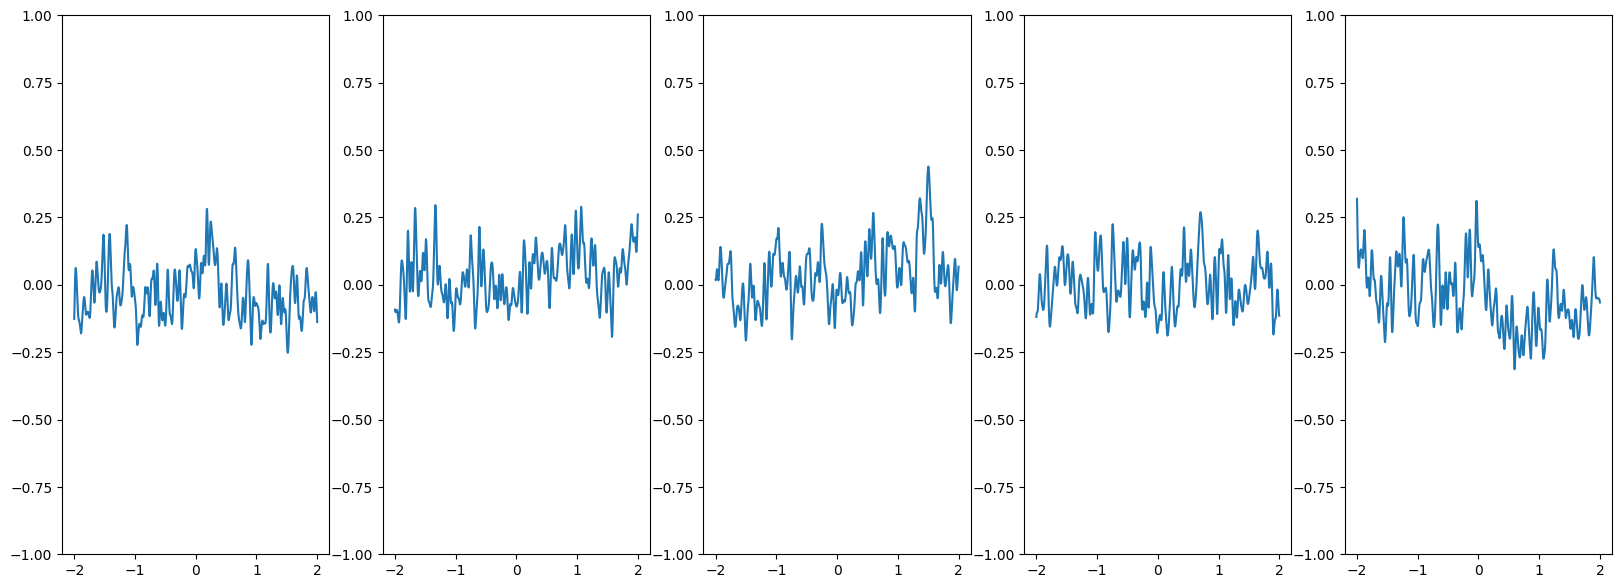

In [ ]:
center_channel = "LQ[X]"
idx_channel = epochs.ch_names.index(center_channel)

# Plot
fig, ax = plt.subplots(1,5, figsize=(20, 7))
for i in range(5):
    ax[i].plot(epochs.times, mean_epochs[i][idx_channel], label=i)
    # Set y limits
    ax[i].set_ylim([-1, 1])

## CSP on TFR-Average Plots

In [37]:
from mne.decoding import CSP
import numpy as np
from sklearn.model_selection import ShuffleSplit
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import warnings

mne.set_log_level("WARNING")
warnings.filterwarnings("ignore")

freq = "beta"
clf = LinearDiscriminantAnalysis()
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

id_pairs = [[2**i, 2**j] for i in range(3, 8) for j in range(i + 1, 8)]

for id_pair in id_pairs:
    indices_to_use = np.where(np.isin(all_epochs.events[:, -1], id_pair))[0]
    data = power_per_epoch_scaled[indices_to_use]
    labels = all_epochs.events[indices_to_use, -1]
    scores = []
    print("Running CSP for", id_pair, end=". ")

    for train_idx, test_idx in cv.split(data):
        train_data_csp = []
        test_data_csp = []

        X_train, y_train = data[train_idx], labels[train_idx]
        X_test, y_test = data[test_idx], labels[test_idx]

        csp = CSP(n_components=4, reg=None, log=True, norm_trace=False).fit(
            X_train, y_train
        )
        train_data_csp.append(csp.transform(X_train))
        test_data_csp.append(csp.transform(X_test))

        X_train_csp = np.hstack(train_data_csp)
        X_test_csp = np.hstack(test_data_csp)

        clf.fit(X_train_csp, y_train)
        score = clf.score(X_test_csp, y_test)
        scores.append(score)

    print(
        "Accuracy: %0.2f (+/- %0.2f)"
        % (np.mean(scores) * 100, np.var(scores*100)* 2)
    )


Running CSP for [8, 16]. Accuracy: 51.61 (+/- 0.03)
Running CSP for [8, 32]. Accuracy: 52.90 (+/- 0.02)
Running CSP for [8, 64]. Accuracy: 47.50 (+/- 0.01)
Running CSP for [8, 128]. Accuracy: 44.38 (+/- 0.01)
Running CSP for [16, 32]. Accuracy: 57.42 (+/- 0.00)
Running CSP for [16, 64]. Accuracy: 49.03 (+/- 0.00)
Running CSP for [16, 128]. Accuracy: 52.90 (+/- 0.03)
Running CSP for [32, 64]. Accuracy: 46.88 (+/- 0.01)
Running CSP for [32, 128]. Accuracy: 53.55 (+/- 0.02)
Running CSP for [64, 128]. Accuracy: 46.25 (+/- 0.01)
Done. Average Score: 46.25%


### TRY CSP ON THE TFR-AVERAGED PLOTS (BOTH BETA AND GAMMA BANDS)

### Put again together the classifier on Hilbert transformed on the ACTUAL envelope of the Hilbert Transform. Try on smaller bins (15-20)
